In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import re
import string
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [8]:
data = pd.read_csv('C:/mini project/Spam Text message/SPAM text message 20170820 - Data.csv')
data



,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [9]:
print(data.shape)


(5572, 2)


In [10]:
data.isnull().sum()



Category    0
Message     0
dtype: int64

In [11]:
data['Category'].value_counts()


ham     4825
spam     747
Name: Category, dtype: int64

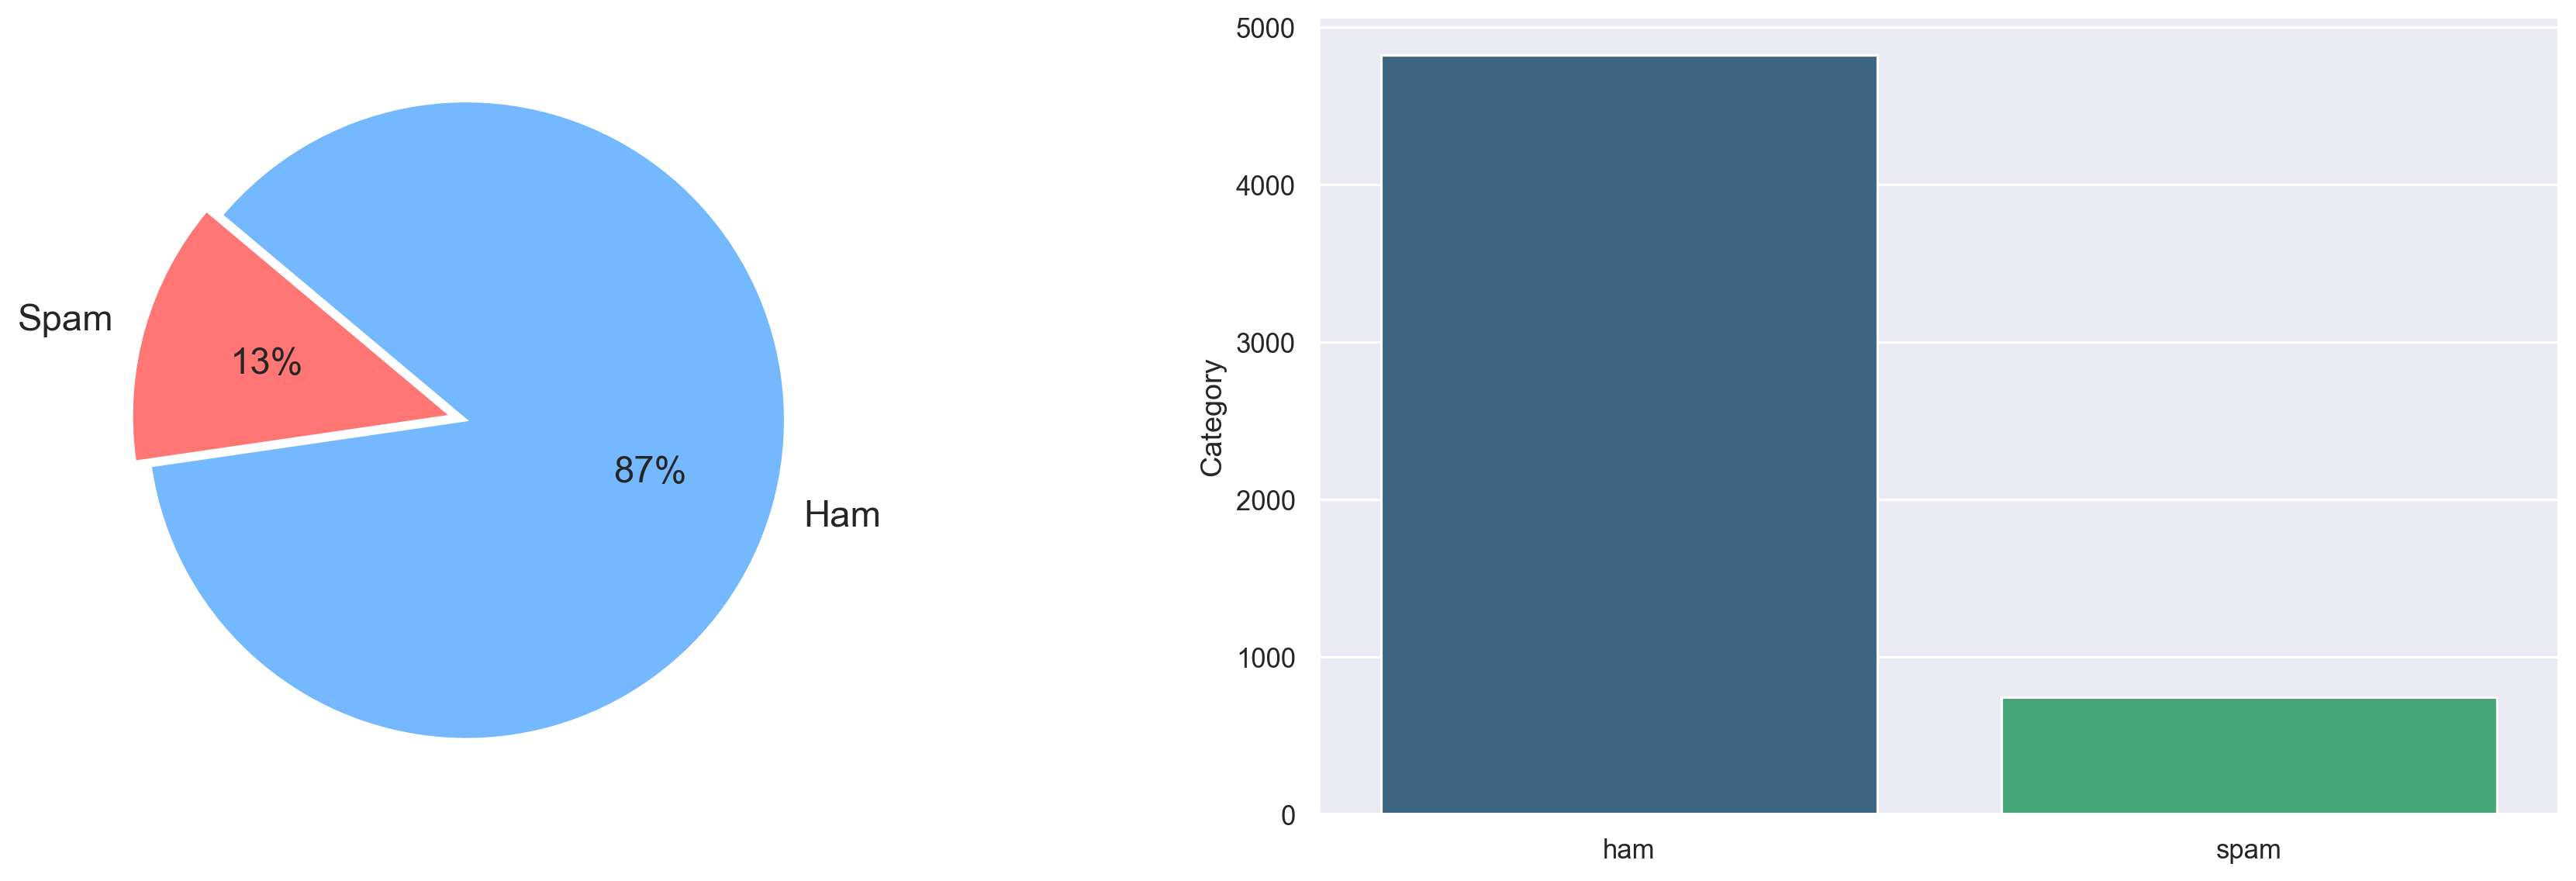

In [12]:
labels = ['Spam', 'Ham']
sizes = [747, 4825]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(20, 6), dpi=227)
plt.subplot(1, 2, 1)
plt.pie(sizes, labels = labels, textprops={'fontsize': 15}, startangle=140, 
       autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.05])

plt.subplot(1, 2, 2)
sns.barplot(x = data['Category'].unique(), y = data['Category'].value_counts(), palette= 'viridis')

plt.show()



In [13]:
data['Total Words'] = data['Message'].apply(lambda x: len(x.split()))

def count_total_words(text):
    char = 0
    for word in text.split():
        char += len(word)
    return char

data['Total Chars'] = data["Message"].apply(count_total_words)

In [14]:
data.head()




,Category,Message,Total Words,Total Chars
0,ham,"Go until jurong point, crazy.. Available only ...",20,92
1,ham,Ok lar... Joking wif u oni...,6,24
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,128
3,ham,U dun say so early hor... U c already then say...,11,39
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,49


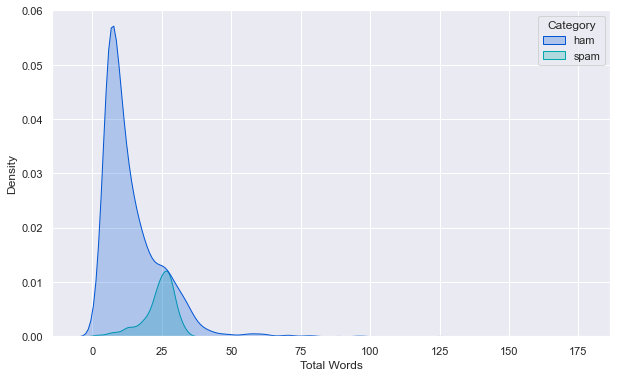

In [15]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Words'], hue= data['Category'], palette= 'winter', shade = True)
plt.show()

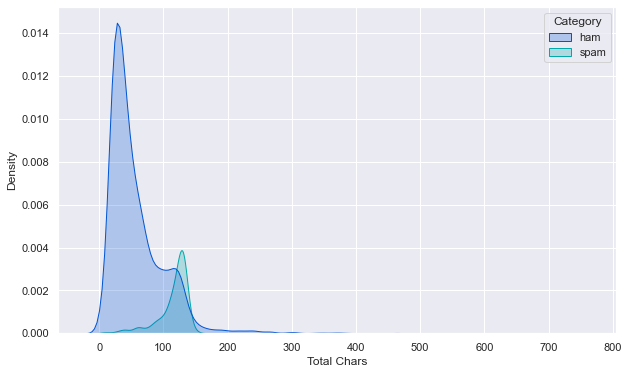

In [16]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = data['Total Chars'], hue= data['Category'], palette= 'winter', shade = True)
plt.show()

In [17]:
# text preprocessing

data.head()


,Category,Message,Total Words,Total Chars
0,ham,"Go until jurong point, crazy.. Available only ...",20,92
1,ham,Ok lar... Joking wif u oni...,6,24
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,128
3,ham,U dun say so early hor... U c already then say...,11,39
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,49


In [18]:
#removing lowercasting

def convert_lowercase(text):
    text = text.lower()
    return text

data['Message'] = data['Message'].apply(convert_lowercase)

In [19]:
#Removing URLs
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

data['Message'] = data['Message'].apply(remove_url)


In [20]:
#Removing Punctuations
exclude = string.punctuation

def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

data['Message'] = data['Message'].apply(remove_punc)

In [22]:
#Removing stopwords
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)



In [23]:
#Stemming
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)



In [24]:
data['Total Words After Transformation'] = data['Message'].apply(lambda x: np.log(len(x.split())))

In [25]:
data.head()

,Category,Message,Total Words,Total Chars,Total Words After Transformation
0,ham,go until jurong point crazy available only in ...,20,92,2.995732
1,ham,ok lar joking wif u oni,6,24,1.791759
2,spam,free entry in 2 a wkly comp to win fa cup fina...,28,128,3.332205
3,ham,u dun say so early hor u c already then say,11,39,2.397895
4,ham,nah i dont think he goes to usf he lives aroun...,13,49,2.564949


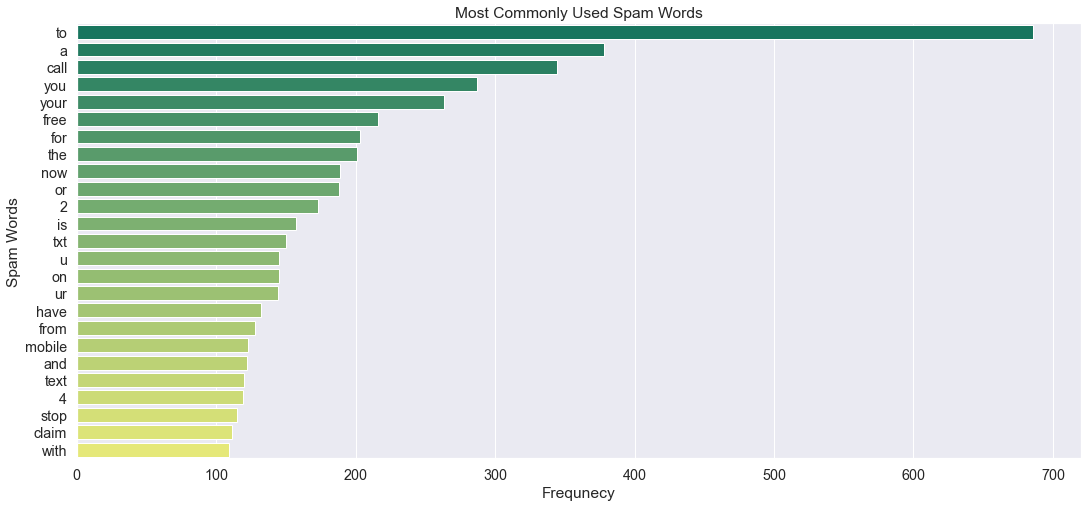

In [27]:
data['Category'] = data['Category'].replace({'spam':0,'ham':1})
all_spam_words = []
for sentence in data[data['Category'] == 0]['Message'].to_list():
    for word in sentence.split():
        all_spam_words.append(word)

df = pd.DataFrame(Counter(all_spam_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Spam Words")
plt.show()

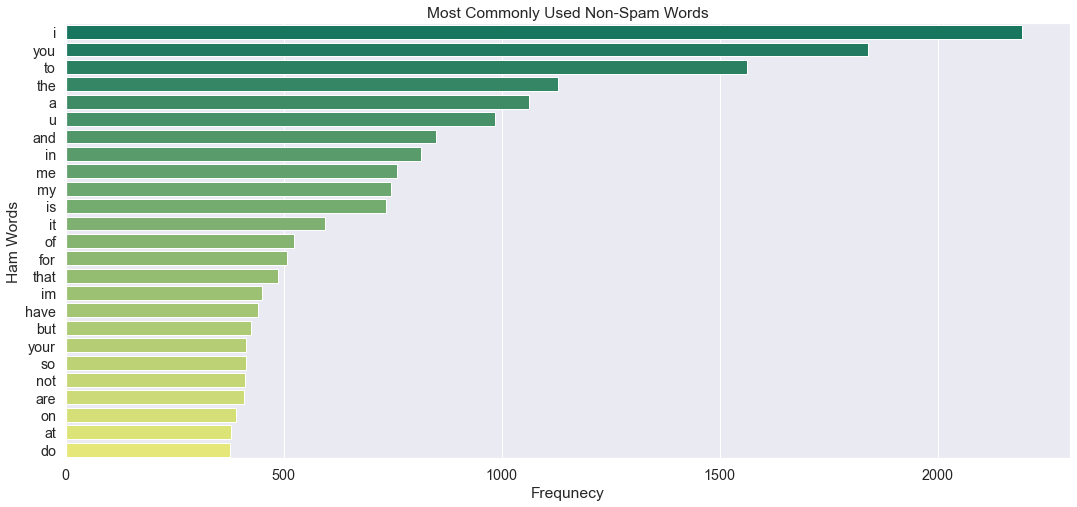

In [28]:
all_ham_words = []
for sentence in data[data['Category'] == 1]['Message'].to_list():
    for word in sentence.split():
        all_ham_words.append(word)

df = pd.DataFrame(Counter(all_ham_words).most_common(25), columns= ['Word', 'Frequency'])

sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df['Word'], x= df['Frequency'], palette= 'summer')
plt.title("Most Commonly Used Non-Spam Words")
plt.xlabel("Frequnecy")
plt.ylabel("Ham Words")
plt.show()

In [29]:
#Text Vectorization
X = data["Message"]
y = data['Category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [37]:
#Naive Bayes
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')



In [38]:
nb = MultinomialNB()
train_model(nb)

Accuracy of the model: 0.964
Precision Score of the model: 0.962
Recall Score of the model: 0.998


In [39]:
nb = MultinomialNB()
train_model(nb)

Accuracy of the model: 0.964
Precision Score of the model: 0.962
Recall Score of the model: 0.998


In [41]:
#Random Forest
rf = RandomForestClassifier(n_estimators= 300)
train_model(rf)

Accuracy of the model: 0.97
Precision Score of the model: 0.966
Recall Score of the model: 1.0
